In [3]:
import numpy as np
from sklearn.decomposition import PCA 
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from lifelines import CoxPHFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib

In [4]:
Tumor_file = pd.read_excel('dataset.xlsx')
dataset = Tumor_file.values

In [14]:
d1 = Tumor_file["置管方式"].values.copy()
d1-=1
tmp1 = Tumor_file["肺部放疗"].values.copy()
tmp2 = Tumor_file["纵隔放疗"].values.copy()
d2 = Tumor_file["胸部治疗"].values.copy()
for i in range(len(tmp2)):
    if tmp2[i] == 1 or tmp1[i] == 1:
        d2[i] = 1

tmp3 = Tumor_file["卵巢癌"].values.copy()
d3  = Tumor_file["宫颈癌"].values.copy()
for i in range(len(tmp3)):
    if tmp3[i] == 1:
        d3[i] = 1

tmp4 = Tumor_file["L肾癌"].values.copy()
tmp5 = Tumor_file["O肾上腺癌"].values.copy()
tmp6 = Tumor_file["M输尿管膀胱"].values.copy()
d4 = Tumor_file["K睾丸癌"].values.copy()
for i in range(len(tmp4)):
    if tmp4[i] == 1 or tmp5[i] == 1 or tmp6[i] == 1:
        d4[i] = 1

data = np.vstack((
    Tumor_file["粒细胞/淋巴细胞"].values.copy(),
    Tumor_file["D二聚体"].values.copy(),
    Tumor_file["化疗"].values.copy(),
    d1,
    d2,
    Tumor_file["本院治疗年龄"].values.copy(),
    Tumor_file["血小板"].values.copy(),
    Tumor_file["血红蛋白"].values.copy(),
    Tumor_file["BMI"].values.copy(),
    # Tumor_file["性别"].values.copy(),
    # Tumor_file["既往置管史"].values.copy(),
    # Tumor_file["既往血栓史"].values.copy(),
    # Tumor_file["肺癌"].values.copy(),
    # Tumor_file["胃癌"].values.copy(),
    # Tumor_file["淋巴瘤"].values.copy(),
    # d3,
    # d4
    )).T
variable_names = [
    "粒细胞/淋巴细胞",
    "D二聚体",
    "化疗",
    "置管方式",
    "胸部治疗",
    "本院治疗年龄",
    "血小板",
    "血红蛋白",
    "BMI",
    # "性别",
    # "既往置管史",
    # "既往血栓史",
    # "肺癌",
    # "胃癌",
    # "淋巴瘤",
    # "妇科肿瘤",
    # "泌尿系统肿瘤"
    ]
tumor = Tumor_file["血栓有1；无0"].values.copy()

dst = Tumor_file["置管日期"].values.copy()
ded = Tumor_file["拔管日期"].values.copy()
during = Tumor_file["血栓发生置管后天数"].values.copy()

for i in range(data.shape[0]):
    if type(dst[i]).__name__ == 'str':
        dst[i] = pd.to_datetime(dst[i])
    if type(ded[i]).__name__ == 'str':
        ded[i] = pd.to_datetime(ded[i])
endtme = pd.to_datetime('2022-06-01')
print(data.shape)
print(endtme)

(20667, 9)
2022-06-01 00:00:00


In [15]:
have_built = 0
Tumor = []
Time = []
for i in range(data.shape[0]):
    flag = True
    for j in range(data.shape[1]):
        if (type(data[i,j]).__name__ != 'float' and type(data[i,j]).__name__ != 'int') or np.isnan(data[i,j]) or data[i,j]<0:
            flag = False
            break
    if np.isnan(tumor[i]):
        flag = False
    if data[i,3] >= 2:
        flag = False
    if flag:
        if tumor[i] == 0:
            Time.append((ded[i]-dst[i]).days)
        else:
            Time.append(during[i])
        if have_built == 0:
            Data = data[i]
            Data = np.reshape(Data,(1,-1))
        else:
            Data = np.vstack((Data,np.reshape(data[i],(1,-1))))
        Tumor.append(tumor[i])
        have_built += 1
print(have_built)


10512


In [12]:
for i in range(Data.shape[0]):
    Data[i][0] = 0 if Data[i][0] < 3.0 else 1
    Data[i][1] = 0 if Data[i][1] < 1.03 else 1
    Data[i][6] = 0 if Data[i][6] < 350 else 1
    Data[i][7] = 0 if Data[i][7] < 100 else 1
    Data[i][8] = 0 if Data[i][8] < 27 else 1
print(Data[0])

[0 0 1 0 0.0 61 0 1 0 2 0 0 0 0]


In [8]:
print(len(set(Time)))

279


In [16]:
#数据处理
dataframe = pd.DataFrame({'time':Time,'event':Tumor})
for i in range(Data.shape[1]):
    dataframe[variable_names[i]] = Data[:,i]
print(dataframe)

       time  event  粒细胞/淋巴细胞  D二聚体 化疗 置管方式 胸部治疗 本院治疗年龄    血小板   血红蛋白  \
0         2      1  1.769231   0.1  1    0  0.0     61  141.0  112.0   
1        64      0   1.22449  1.36  1    1  0.0     57  281.0  115.0   
2        16      1  2.732673   0.1  1    1  0.0     30  267.0  108.0   
3        50      0  2.939086  0.96  1    1  0.0     51  276.0  114.0   
4       101      0  1.172589  3.57  1    1  0.0     52  303.0  121.0   
...     ...    ...       ...   ... ..  ...  ...    ...    ...    ...   
10507    35      0  1.864407  0.14  0    1  0.0     27  292.0  119.0   
10508    30      0  4.288462   0.1  0    1  0.0     62  401.0  110.0   
10509    15      0  5.367647   0.6  0    0  0.0     50  640.0   74.0   
10510    15      0  1.294872   1.3  0    1  0.0     64  138.0  122.0   
10511    15      1     11.65  0.53  0    0  0.0     70  169.0  131.0   

             BMI  
0      22.313278  
1      23.805402  
2      26.037494  
3      22.038567  
4      20.811655  
...          ...  
10

# Kaplan-Meier方法

(10512, 11)


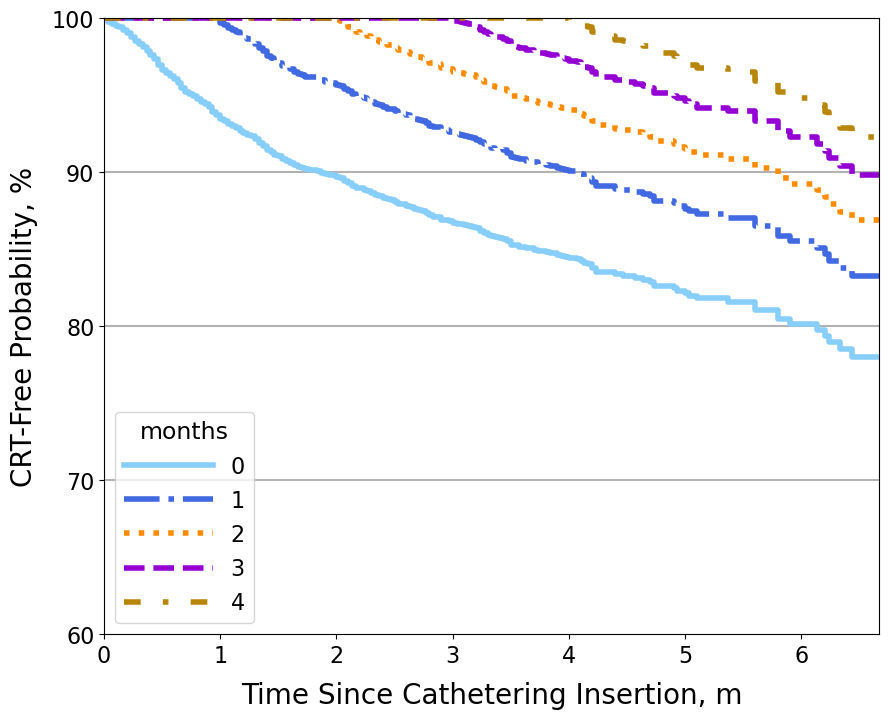

In [39]:
#画图
df_1 = dataframe[dataframe['time']>=30]
df_2 = dataframe[dataframe['time']>=60]
df_3 = dataframe[dataframe['time']>=90]
df_4 = dataframe[dataframe['time']>=120]

print(dataframe.shape)

kmf = KaplanMeierFitter(label='0')
kmf_1 = KaplanMeierFitter(label='1')
kmf_2 = KaplanMeierFitter(label='2')
kmf_3 = KaplanMeierFitter(label='3')
kmf_4 = KaplanMeierFitter(label='4')

kmf.fit(dataframe.time,dataframe.event)
kmf_1.fit(df_1.time,df_1.event)
kmf_2.fit(df_2.time,df_2.event)
kmf_3.fit(df_3.time,df_3.event)
kmf_4.fit(df_4.time,df_4.event)

plt1,ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0,200)
ax.set_ylim(0.6,1)
ax.set_xticks(range(0,200,30))
ax.set_xticklabels(['0','1','2','3','4','5','6'],fontsize=16)
ax.set_yticks(np.arange(0.6,1.01,0.1))
ax.set_yticklabels(['60','70','80','90','100'],fontsize=16)

ax.axhline(y=0.9, color='black', alpha=0.3)
ax.axhline(y=0.8, color='black', alpha=0.3)
ax.axhline(y=0.7, color='black', alpha=0.3)
# ax.axhline(y=0.6, color='black', alpha=0.3)

kmf.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='lightskyblue',linewidth=4)
kmf_1.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='royalblue',linewidth=4,linestyle='-.')
kmf_2.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkorange',linewidth=4,linestyle=':')
kmf_3.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkviolet',linewidth=4,linestyle='--')
kmf_4.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkgoldenrod',linewidth=4,linestyle=(0, (3, 4, 1, 4, 3, 4)))
legend = ax.legend(loc='lower left',prop={'size': 16},title='months',title_fontsize=17,handlelength=4)
ax.set_ylabel('CRT-Free Probability, %',fontsize=20,labelpad=10)
ax.set_xlabel('Time Since Cathetering Insertion, m',fontsize=20,labelpad=10)
plt.show()

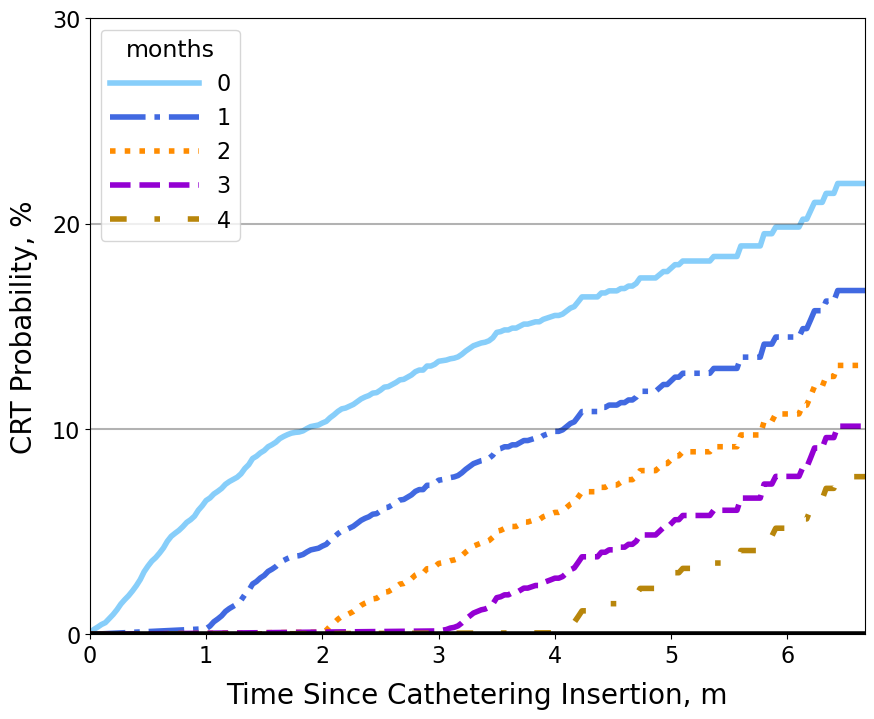

In [21]:
plt1,ax = plt.subplots(figsize=(10,8))

kmf_anti = 1-kmf.survival_function_
kmf1_anti = 1-kmf_1.survival_function_
kmf2_anti = 1-kmf_2.survival_function_
kmf3_anti = 1-kmf_3.survival_function_
kmf4_anti = 1-kmf_4.survival_function_
ax.plot(kmf_anti.index,kmf_anti.values, color='lightskyblue',linewidth=4,label='0')
ax.plot(kmf1_anti.index,kmf1_anti.values, color='royalblue',linewidth=4,linestyle='-.',label='1')
ax.plot(kmf2_anti.index,kmf2_anti.values, color='darkorange',linewidth=4,linestyle=':',label='2')
ax.plot(kmf3_anti.index,kmf3_anti.values, color='darkviolet',linewidth=4,linestyle='--',label='3')
ax.plot(kmf4_anti.index,kmf4_anti.values, color='darkgoldenrod',linewidth=4,linestyle=(0, (3, 5, 1, 5, 3, 5)),label='4')

ax.axhline(y=0, color='black', alpha=1,linewidth=4)
ax.axhline(y=0.1, color='black', alpha=0.3)
ax.axhline(y=0.2, color='black', alpha=0.3)
ax.axhline(y=0.3, color='black', alpha=0.3)
ax.axhline(y=0.4, color='black', alpha=0.3)

legend = ax.legend(loc='upper left',prop={'size': 16},title='months',title_fontsize=17,handlelength=4)
ax.set_xlim(0,200)
ax.set_ylim(0,0.3)
ax.set_xticks(range(0,200,30))
ax.set_xticklabels(['0','1','2','3','4','5','6'],fontsize=16)
ax.set_yticks(np.arange(0.0,0.31,0.1))
ax.set_yticklabels(['0','10','20','30'],fontsize=16)

ax.set_ylabel('CRT Probability, %',fontsize=20,labelpad=10)
ax.set_xlabel('Time Since Cathetering Insertion, m',fontsize=20,labelpad=10)
plt.show()

In [167]:
print(plt.rcParams['font.family'])

['sans-serif']


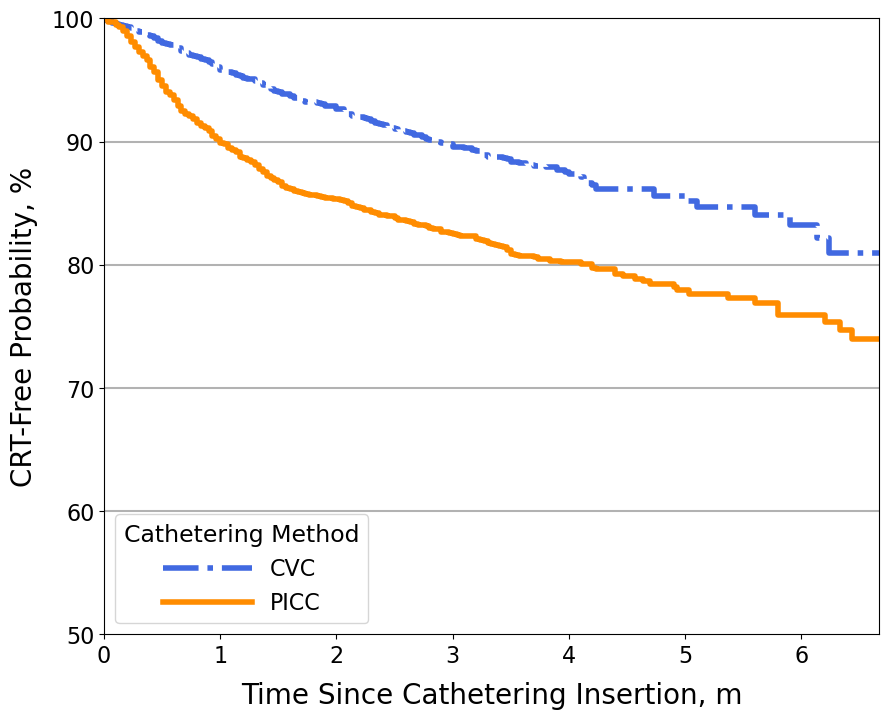

In [22]:
df_cvc = dataframe[dataframe['Variable4'] == 0]
df_picc = dataframe[dataframe['Variable4'] == 1]

plt1,ax = plt.subplots(figsize=(10,8))
kmf_cvc = KaplanMeierFitter(label='CVC')
kmf_picc = KaplanMeierFitter(label='PICC')

kmf_cvc.fit(df_cvc.time,df_cvc.event)
kmf_picc.fit(df_picc.time,df_picc.event)

ax.set_xlim(0,200)
ax.set_ylim(0.5,1)
ax.set_xticks(range(0,200,30))
ax.set_xticklabels(['0','1','2','3','4','5','6'],fontsize=16)
ax.set_yticks(np.arange(0.5,1.01,0.1))
ax.set_yticklabels(['50','60','70','80','90','100'],fontsize=16)

ax.axhline(y=0.9, color='black', alpha=0.3)
ax.axhline(y=0.8, color='black', alpha=0.3)
ax.axhline(y=0.7, color='black', alpha=0.3)
ax.axhline(y=0.6, color='black', alpha=0.3)

kmf_cvc.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='royalblue',linewidth=4,linestyle='-.')
kmf_picc.plot_survival_function(at_risk_counts=False, ci_show=False ,ax=ax, color='darkorange',linewidth=4)
legend = ax.legend(loc='lower left',prop={'size': 16},title='Cathetering Method',title_fontsize=17,handlelength=4)
ax.set_ylabel('CRT-Free Probability, %',fontsize=20,labelpad=10)
ax.set_xlabel('Time Since Cathetering Insertion, m',fontsize=20,labelpad=10)
plt.show()

# Cox风险回归模型

In [17]:
#Cox风险回归模型
train_set,test_set = train_test_split(dataframe,test_size=0.2,random_state=42)
cph = CoxPHFitter(penalizer=0.005)
cph.fit(train_set,duration_col='time',event_col='event')
cph.print_summary()
# cph.check_assumptions(train_set,p_value_threshold=0.05,show_plots=True)

<lifelines.CoxPHFitter: fitted with 8409 total observations, 7592 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.005
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 8409
number of events observed = 817
   partial log-likelihood = -6759.13
         time fit was run = 2024-04-15 00:37:15 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
粒细胞/淋巴细胞   0.01      1.01      0.01           -0.00            0.02                1.00                1.02
D二聚体       0.01      1.01      0.01           -0.01            0.03                0.99                1.03
化疗         0.27      1.31      0.11            0.05            0.49                1.05                1.63
置管方式       0.49      1.64      0.07            0.35            0.63                1.42                1.88
胸部治疗       0.82      2.28      0.11            0.61            1.03                1.85                2.81
本院治疗年龄     0.02      1.02      0.00            0.02            0.03                1.02                1.03
血小板       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
血红蛋白       0.01      1.01      0.00            0.00            0.01                1.00                1.01
BMI       -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99

           cmp to     z      p  -log2(p)
covariate                               
粒细胞/淋巴细胞     0.00  1.18   0.24      2.06
D二聚体         0.00  1.22   0.22      2.17
化疗           0.00  2.37   0.02      5.83
置管方式         0.00  6.86 <0.005     37.06
胸部治疗         0.00  7.71 <0.005     46.13
本院治疗年龄       0.00  7.77 <0.005     46.83
血小板          0.00 -0.67   0.50      0.99
血红蛋白         0.00  3.40 <0.005     10.53
BMI          0.00 -3.01 <0.005      8.57
---
Concordance = 0.66
Partial AIC = 13536.26
log-likelihood ratio test = 249.13 on 9 df
-log2(p) of ll-ratio test = 158.84

In [54]:
print(dataframe['event'])

0        1
1        0
2        1
3        0
4        0
        ..
10507    0
10508    0
10509    0
10510    0
10511    1
Name: event, Length: 10512, dtype: int64


In [11]:
import joblib
joblib.dump(cph,'cph.pkl')

['cph.pkl']

In [18]:
# prediction_probs = cph.predict_cumulative_hazard(test_set).T
prediction_probs = cph.predict_survival_function(test_set).T
# corr_prediction_probs = prediction_probs.apply(lambda c: (c/c.loc[dataframe.loc[c.name,'time']]).clip(upper=1),axis=1)
# prediction_probs = 1-prediction_probs
# corr_prediction_probs = 1-corr_prediction_probs
print(prediction_probs.shape)

(2103, 274)


In [183]:
print(prediction_probs.shape)
# prediction_probs.iloc[k].plot(ls="--")
# corr_prediction_probs.iloc[k].plot()
health_sum = []
tumor_sum = []
num_month = 10
for i in range(num_month):
    health_sum.append([])
    tumor_sum.append([])
for k in range(prediction_probs.shape[0]):
    # print(dataframe.loc[prediction_probs.iloc[k].name,'event'],prediction_probs.iloc[k,-1],corr_prediction_probs.iloc[k,-1])
    for i in range(num_month):
        if dataframe.loc[prediction_probs.iloc[k].name,'event'] == 1:
            tumor_sum[i].append(prediction_probs.iloc[k,30*i])
        else :
            health_sum[i].append(prediction_probs.iloc[k,30*i])
for i in range(num_month):
    print('{} days predicted_probability  Tumor:{:.2f}%   Health:{:.2f}%'.format(i*30,np.mean(tumor_sum[i])*100,np.mean(health_sum[i])*100))

(2103, 274)
0 days predicted_probability  Tumor:99.88%   Health:99.92%
30 days predicted_probability  Tumor:90.51%   Health:93.78%
60 days predicted_probability  Tumor:84.92%   Health:89.94%
90 days predicted_probability  Tumor:79.91%   Health:86.37%
120 days predicted_probability  Tumor:76.29%   Health:83.70%
150 days predicted_probability  Tumor:73.41%   Health:81.54%
180 days predicted_probability  Tumor:71.91%   Health:80.39%
210 days predicted_probability  Tumor:68.55%   Health:77.77%
240 days predicted_probability  Tumor:66.64%   Health:76.24%
270 days predicted_probability  Tumor:66.64%   Health:76.24%


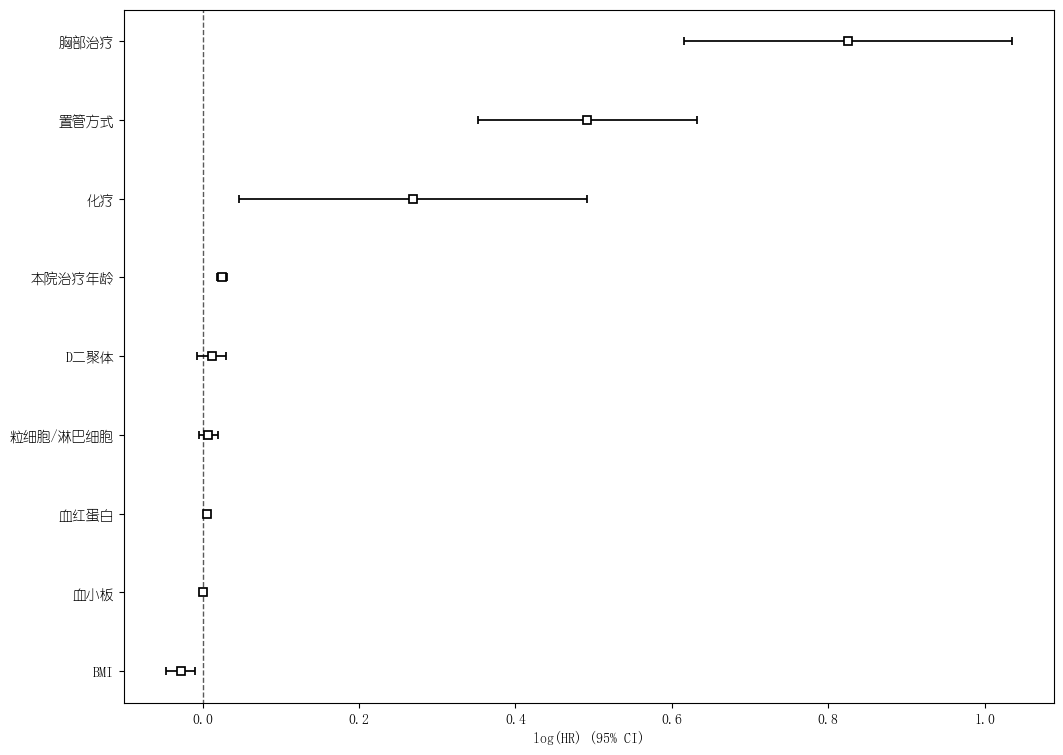

In [19]:
matplotlib.rc("font",family="YouYuan")
fig,ax = plt.subplots(figsize=(12,9))
cph.plot(ax=ax)
plt.show()

              2
0.0    0.999620
1.0    0.998803
2.0    0.998200
3.0    0.997697
4.0    0.997297
...         ...
374.0  0.870485
392.0  0.870485
397.0  0.870485
408.0  0.870485
464.0  0.870485

[274 rows x 1 columns]


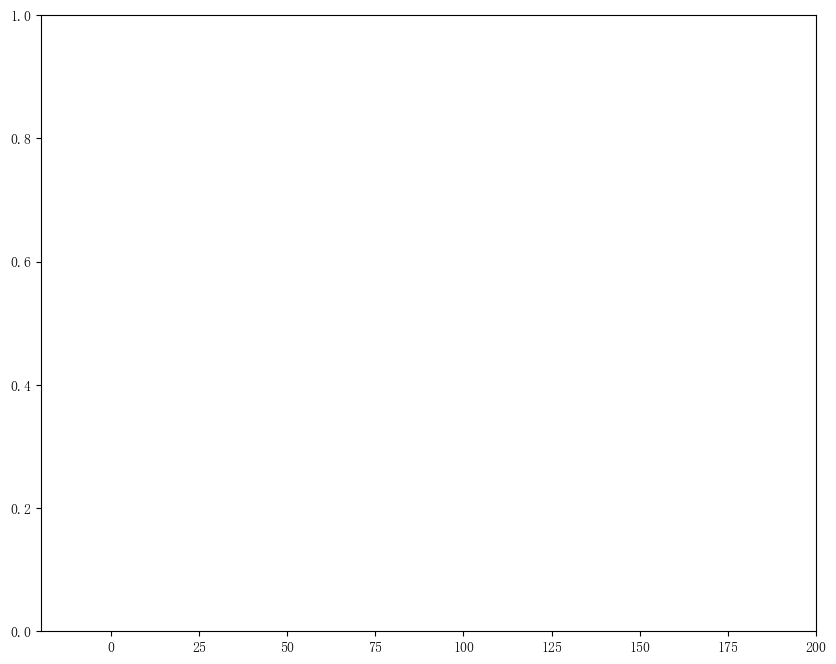

In [188]:
plt2,ax = plt.subplots(figsize=(10,8))
ax.set_xlim(-20,200)
certain_prob = cph.predict_survival_function(dataframe.iloc[2])
# for i in range(moment_prob.shape[0]-1,1,-1):
#     moment_prob[i] -= moment_prob[i-1]
print(certain_prob)
# moment_prob.plot(ax=ax)

In [71]:
from lifelines.utils import concordance_index
concordance_index(test_set['time'],-cph.predict_partial_hazard(test_set),test_set['event'])

0.6828619810421005

# 随机生存森林

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sksurv.datasets import get_x_y

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ExtraSurvivalTrees

In [61]:
tmp = [(Tumor[i],Time[i]) for i in range(len(Tumor))]
tmp = np.array(tmp,dtype=[('event',bool),('time',float)])
print(tmp)

[( True,  2.) (False, 64.) ( True, 16.) ... (False, 15.) (False, 15.)
 ( True, 15.)]


In [64]:
data_x,data_y = get_x_y(dataframe,attr_labels=['event','time'],pos_label=1,survival=True)
# data_y = np.array(data_y)
X_train,X_test,y_train,y_test = train_test_split(data_x,data_y,test_size=0.2,random_state=42)

In [90]:
gbc = GradientBoostingSurvivalAnalysis(n_estimators=100,learning_rate=0.01,max_depth=3)
gbc.fit(X_train,y_train)
gbc.score(X_test,y_test)

0.6416781828444634

In [84]:
rsf = RandomSurvivalForest(
    n_estimators=1000,max_depth=9,min_samples_split=15, min_samples_leaf=8, n_jobs=-1, random_state=42
)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

0.6718843062070576

In [97]:
est = ExtraSurvivalTrees(n_estimators=1000,max_depth=7,min_samples_split=20, min_samples_leaf=10, random_state=42)
est.fit(X_train, y_train)
est.score(X_test, y_test)

0.6864939564396519